In [45]:
import pandas as pd
import torch
import numpy as np
from src.utils.finger import encode, dense2sparse
from src.utils.modelinit import initialize_model
from io import BytesIO
import pickle
from scipy.spatial.distance import jaccard, euclidean, cosine

In [2]:
# load validation det for klek
df_klek = pd.read_parquet('data/train_data/big_dataset_std_val_10.parquet').sample(1000)

# load validation set for ECFP
df_ECFP = pd.read_parquet('data/train_data/big_dataset_ECFP_val_10.parquet').sample(1000)

In [3]:
def unpack(bs):
    bs = str(bs)
    bs = bs.lstrip("b'[").rstrip("']").split(',')
    bs = [int(x) for x in bs]
    return bs

def repack(bs, lg):
    vec = np.zeros(lg)
    vec[bs] = 1
    return vec

In [4]:
df_klek['fps'] = df_klek['fps'].apply(unpack)
df_ECFP['fps'] = df_ECFP['fps'].apply(unpack)
klek_original = df_klek['fps'].apply(repack, lg=4860)
ECFP_original = df_ECFP['fps'].apply(repack, lg=2048)
klek_original = np.array([x for x in klek_original.to_numpy()])
ECFP_original = np.array([x for x in ECFP_original.to_numpy()])

In [5]:
# path to klek model weights
klek_path = 'models/GRUv3_klek_sonic/epoch_200.pt'
klek_config_path = 'models/GRUv3_klek_sonic/hyperparameters.ini'

# path to ECFP model weights
ECFP_path = 'models/GRUv3_ECFP_tola/epoch_150.pt'
ECFP_config_path = 'models/GRUv3_ECFP_tola/hyperparameters.ini'

In [6]:
# initialize models and load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

klek_model = initialize_model(klek_config_path, dropout=False, device=device)
klek_model.load_state_dict(torch.load(klek_path, map_location=device))

ECFP_model = initialize_model(ECFP_config_path, dropout=False, device=device)
ECFP_model.load_state_dict(torch.load(ECFP_path, map_location=device))

<All keys matched successfully>

In [7]:
# encode fingerprints
klek_encoded, _ = encode(df_klek, klek_model, device)
ECFP_encoded, _ = encode(df_ECFP, ECFP_model, device)

print(klek_encoded.shape) # (10000, 32)
print(ECFP_encoded.shape) # (10000, 32)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

(1000, 32)
(1000, 32)


In [8]:
print(klek_encoded.shape)
print(klek_original.shape)
print(ECFP_encoded.shape)
print(ECFP_original.shape)

(1000, 32)
(1000, 4860)
(1000, 32)
(1000, 2048)


In [43]:
def calculate_tanimoto(array):
    res = []
    for i in range(array.shape[0]):
        for j in range(i+1, array.shape[0]):
            res.append(jaccard(array[i, :], array[j,:]))
    return res

def calculate_euclidean(array):
    res = []
    for i in range(array.shape[0]):
        for j in range(i+1, array.shape[0]):
            res.append(euclidean(array[i, :], array[j,:]))
    return res
def calculate_cosine(array):
    res = []
    for i in range(array.shape[0]):
        for j in range(i+1, array.shape[0]):
            res.append(cosine(array[i, :], array[j,:]))
    return res

In [150]:
klek_tan = calculate_tanimoto(klek_original)
klek_euc = calculate_cosine(klek_encoded)

ECFP_tan = calculate_tanimoto(ECFP_original)
ECFP_euc = calculate_cosine(ECFP_encoded)

In [47]:
print(len(klek_tan))
print(len(klek_euc))
print(len(ECFP_tan))
print(len(ECFP_euc))

499500
499500
499500
499500


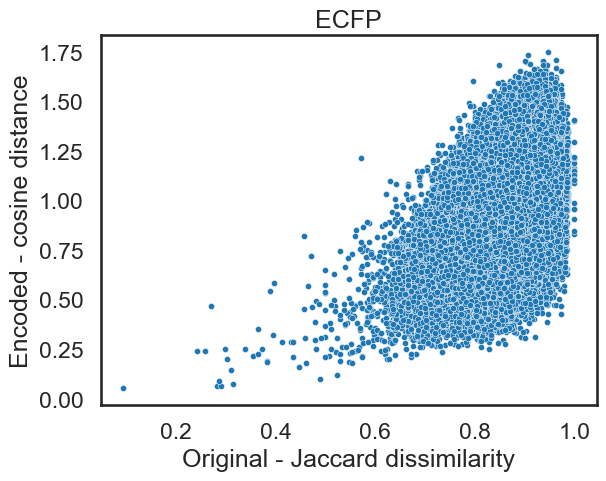

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({'Klek_original': klek_tan, 'Klek_encoded': klek_euc, 'ECFP_original': ECFP_tan, 'ECFP_encoded': ECFP_euc})

sns.set_style('white')
sns.set_context('talk')
sns.scatterplot(data=df, x = 'ECFP_original', y='ECFP_encoded', s=20)

plt.xlabel('Original - Jaccard dissimilarity')
plt.ylabel('Encoded - cosine distance')
plt.title('ECFP')
plt.savefig(f'./ECFP.png', dpi=300, bbox_inches='tight')
plt.show()

In [153]:
from sklearn.linear_model import LinearRegression

In [154]:
from sklearn.preprocessing import MinMaxScaler

In [155]:
X = df['ECFP_original'].to_numpy().reshape(-1, 1)
y = df['ECFP_encoded'].to_numpy().reshape(-1, 1)

X_scaled = MinMaxScaler().fit(X).transform(X)
y_scaled = MinMaxScaler().fit(y).transform(y)

In [156]:
LR = LinearRegression().fit(X, y)

In [157]:
print(LR.coef_)
print(LR.intercept_)

[[1.90778667]]
[-0.69597851]


In [54]:
from sklearn.metrics import r2_score

In [55]:
print(r2_score(y, X))

-0.48308726343837827


In [56]:
df = pd.DataFrame({'Original': X_scaled.reshape(-1), 'Encoded': y_scaled.reshape(-1)})

<Axes: >

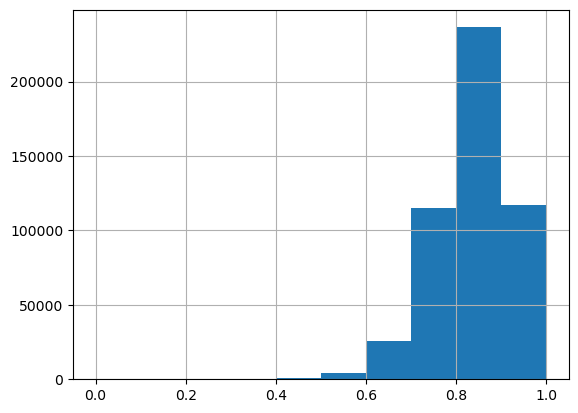

In [57]:
df['Original'].hist()

<Axes: >

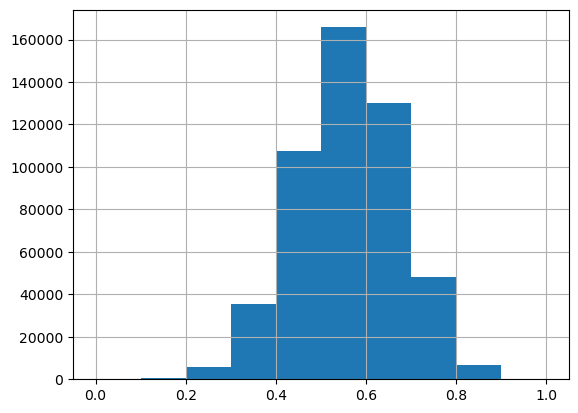

In [58]:
df['Encoded'].hist()

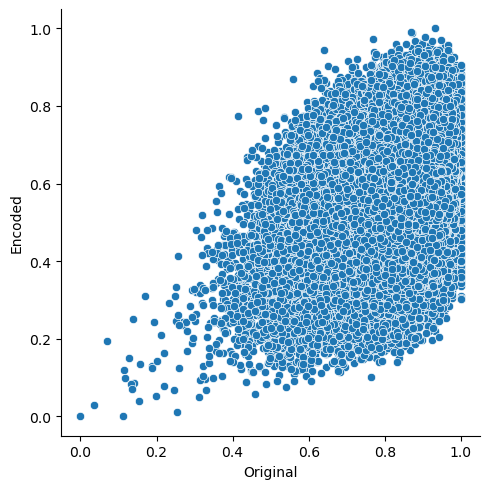

In [59]:
sns.relplot(df, x='Original', y='Encoded')
plt.show()

In [148]:
one = np.array([1,0,0,1,1,0,1])
two = np.array([0,1,1,0,0,1,1])
jaccard(one,two)

0.8571428571428571

In [139]:
klek_encoded, _ = encode(df_klek, klek_model, device)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


In [140]:
huh = calculate_euclidean(klek_encoded)

In [141]:
mean_starting = np.mean(huh)

In [143]:
klek_encoded = klek_encoded[klek_encoded[0, ...] < 0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 32

In [135]:
klek_encoded 

(16020,)

In [134]:
mean_new = np.mean(calculate_euclidean(klek_encoded))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed